# Applying machine learning algorithms on MIMIC

## Patient Monitoring and Decision Support using Health Data

**Notebook by Olivier Nguyen (Github: [olinguyen](http://github.com/olinguyen)) for GSoC 2017**

**Mentors: [Lea Goetz](https://github.com/lgoetz), [Heiko Strathmann](https://github.com/karlnapf)**

### Introduction

Everyday, the healthcare industry creates large amounts of patient and clinical data and stores them in electronic health records. Most of this data has previously been inaccessible, in part due to patient privacy concerns, which poses a challenge to researchers working on the analysis of health records.

However, initatives like the Medical Information Mart For Intensive Care (MIMIC) database project have allowed for everyone to use and experiment with health data. In particular, the MIMIC database is a critical care database made freely available for researchers around the world to develop and evaluate intensive care unit (ICU) patient monitoring and decision support systems that will improve the efficiency, accuracy and timeliness of clinical decision-making in critical care.

### Objective

In the [previous notebook](https://github.com/olinguyen/gsoc2017-shogun-dataproject/blob/master/Exploring MIMIC.ipynb), we were introduced to the MIMIC database to better understand the dataset and visualize its contents. In this notebook, we'll dive into the data analysis component of this project. Using the MIMIC database which includes vital signs, medications, diagnostic code and many more variables, along with feature engineering techniques, I investigated whether I could build a robust classifier to perform the following tasks which can be used to help hospitals and care units make decisions about the management of resources and staffing:

* **Mortality prediction**: Patient mortality is a primary outcome of interest in hospital settings, therefore early detection of at-risk patients is important. Mortality prediction is formulated as a binary classification problem, where the target label is whether the patient died before hospital discharge, or within a fixed time window e.g. likelihood of dying in 1 day, 1 week or 1 month in time.

* **Hospital length of stay**: Forecasting the hospital lenght of stay of a patient is also an important problem that could help manage hospital resources and cost. This can be formulated as a regression task where the amount of days that a patient is likely to spend at the hospital is predicted.

I first experimented with a basic model which ignores temporal structure in the data, and attempted to perform mortality prediction. Briefly, for the first model, I completed the following tasks:

1. Extracted predictor variables from the MIMIC database
2. Built machine learning models for the predictions tasks
3. Evaluated and compared the performance of various algorithms

In the second improved model, I took into account the complexity of time series data, since past vital signs and how they previously fluctuated can be strong indicators of the current condition of a patient. The improved model of patient mortality is still a binary classification, but I now included temporal features from the time series of the vital signs data. For example, I added information about the health state of the patient from previous points in time e.g. the previous hours, the mean/median/min/max value of the last 6 hours, etc.

## Feature extraction

Predictors from three main categories were extracted: demographic information, vital sign data and laboratory measurements. These were selected as the most relevant information in determining the likelihood of mortality and hospital length of stay.

| Demographic & Clinical Info             | Description |
|-------------------------|---------------------------------------------|
| Age                     | Age of the patient upon entering the ICU    |
| Gender                  | Patient gender (male or female)             |
| Hospital length of stay | Number of days spent in the hospital        |
| ICU length of stay      | Number of days spent in the ICU             |
| First care unit         | ICU type in which the patient was cared for |
| Admission type          | Admission type the patient entered          |

Vital signs are clinical measurements that describe the state of a patient's body functions.

| Vital sign               | Description |
|--------------------------|-------------|
| Heart Rate               | Heartbeat rate of the patient |
| Mean Blood Pressure      | Average pressure in a patient's arteries during one cardiac cycle       |
| Diastolic blood pressure | Pressure when the heart is at rest between beats            |
| Systolic blood pressure  | Pressure when the heart is beating |
| Respiratory Rate         | Number of breaths taken per minute       |
| Temperature              | Temperature of a patient in degrees Celcius            |
| SpO2                     | Amount of oxygen in the blood            |
| Glasgow Coma Scale       | Scoring system used to describe the level of consciousness in a person            |
| Ventilation              | Whether the patient was ventilated or not            |
| Urine output             | How much urine was produced            |

Laboratory measurements are made by acquiring a fluid from the patient's body (e.g. blood from an arterial line or urine from a [catheter](https://en.wikipedia.org/wiki/Catheter)) and then analyzing it in the laboratory.

| Laboratory measurements |
|-------------------------|
| Aniongap                |
| Bicarbonate             |
| Creatinine              |
| Chloride                |
| Glucose                 |
| Hematocrit              |
| Hemoglobin              |
| Platelet                |
| Potassium               |
| Sodium                  |
| Blood urea nitrogen     |
| White blood cells       |

In [2]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
import getpass
from scipy import interp
from shogun import *
from scripts import utils
import os
import time

SHOGUN_DATA_DIR = os.getenv('SHOGUN_DATA_DIR', '../../../data')

# below imports are used to print out pretty pandas dataframes
from IPython.display import display, HTML

%matplotlib inline
plt.style.use('ggplot')

In [4]:
# SQL database config
sqluser = ''
dbname = 'MIMIC3'
schema_name = 'mimiciii'
hostname = ''
port = 5432
pwd = getpass.getpass()

········


In [5]:
# Connect to local postgres version of mimic
con = psycopg2.connect(dbname=dbname, user=sqluser, host=hostname, port=5432, password=pwd)
cur = con.cursor()
cur.execute('SET search_path to ' + schema_name)

In [ ]:
sql_path = os.path.join(SHOGUN_DATA_DIR, 'data_project/mimic/first-icustay.sql')
with open(sql_path, 'r') as f:
    query = f.read()
    query_output = pd.read_sql_query(query, con)

query_output = pd.read_sql_query(query, con)
query_output.head()

### Selection Criteria

Because MIMIC is an ICU database, the focus was placed on patients admitted to and discharged from the ICU. Patients admitted to the ICU generally suffer from severe and life-threatening illnesses and injuries which require constant, close monitoring and support. Being able to make good decisions during this time period is therefore crucial. For that reason, data points were queried and grouped based off the ICU stay rather than the individual patient to develop a model specifically for ICU patient monitoring and decision-making.

The selection criteria is described below along with a short explanation. The following points were excluded from the dataset:

* Patients aged less than 16 years old
    * This also removed neonates and children, which likely have different predictors than adults
* Second admissions of patients
    * Simplifies analysis which assumes independent observations
    * We avoid taking into account that ICU stays are highly correlated
* Length of stay less than 2 days
    * Helps remove false positives that were placed in ICU for precautionary purposes

In [21]:
query_output.first_careunit = pd.Categorical(query_output.first_careunit)
query_output.gender = pd.Categorical(query_output.gender)
query_output.admission_type = pd.Categorical(query_output.admission_type)

query_output['gender'] = query_output.gender.cat.codes
query_output['first_careunit'] = query_output.first_careunit.cat.codes
query_output['admission_type'] = query_output.admission_type.cat.codes

query_output = query_output[(query_output.exclusion_los == 0) & (query_output.exclusion_age == 0) 
                            & (query_output.exclusion_first_stay == 0) ]#& (query_output.age_icu_in < 250)]

# Median age of patients > 89 is 91.6
query_output.loc[query_output.age_icu_in > 89, 'age_icu_in'] = 91.6

mortality_names = ['hospital_expire_flag', 'icu_expire_flag', 
                   'hospital1day_expire_flag', 'hospital7day_expire_flag', 
                   'hospital30day_expire_flag']

los_names = ['hosp_los', 'icu_los']

feature_names = [
            # Demographic information
            'age_icu_in', 'gender', 'first_careunit',
            'admission_type',
    
            # Vital signs
            'heartrate_min', 'heartrate_max', 'heartrate_mean',
            'meanbp_min', 'meanbp_max', 'meanbp_mean',
            'diasbp_min', 'diasbp_max', 'diasbp_mean',
            'sysbp_min', 'sysbp_max', 'sysbp_mean',
            'resprate_min', 'resprate_max', 'resprate_mean',
            'tempc_min', 'tempc_max', 'tempc_mean',
            'spo2_min', 'spo2_max', 'spo2_mean',
    
            'mingcs', 'gcsmotor',
            'gcsverbal', 'gcseyes',
                 
            # Laboratory measurements
            'aniongap_min', 'aniongap_max',
            'bicarbonate_min', 'bicarbonate_max',
            'creatinine_min', 'creatinine_max',
            'chloride_min', 'chloride_max',
            'glucose_min', 'glucose_max',
            'hematocrit_min', 'hematocrit_max',
            'hemoglobin_min', 'hemoglobin_max',
            'platelet_min', 'platelet_max',
            'potassium_min', 'potassium_max',
            'sodium_min', 'sodium_max',
            'bun_min', 'bun_max',
            'wbc_min', 'wbc_max',                 

            # Other
            'vent', 
            'urineoutput'
            
            ]

query_output = query_output.loc[:, mortality_names + feature_names][:10000]
query_output = query_output.fillna(query_output.mean()).reset_index(drop=True)[:10000]

#query_output = query_output.loc[:, mortality_names + feature_names].dropna().reset_index(drop=True) # drop NaNs

outcomes = query_output.loc[:, mortality_names]
features = query_output.loc[:, query_output.columns.difference(mortality_names + los_names)]

#print(len(query_output))
query_output.head()

,hospital_expire_flag,icu_expire_flag,hospital1day_expire_flag,hospital7day_expire_flag,hospital30day_expire_flag,age_icu_in,gender,first_careunit,admission_type,heartrate_min,...,potassium_min,potassium_max,sodium_min,sodium_max,bun_min,bun_max,wbc_min,wbc_max,vent,urineoutput
0,0,0,0,0,0,74.384648,1,1,0,74.0,...,3.8,5.2,136.0,141.0,13.0,17.0,6.9,6.9,1,2760.0
1,0,0,0,0,0,68.933751,1,2,1,69.0,...,3.8,4.0,139.0,143.0,25.0,37.0,10.4,13.9,0,2730.0
2,0,0,0,0,0,48.625771,1,2,1,56.0,...,3.4,3.4,138.0,138.0,9.0,9.0,1.6,1.6,0,650.0
3,0,0,0,0,1,60.329137,0,5,1,42.0,...,3.9,4.5,137.0,140.0,7.0,9.0,11.3,12.2,0,2967.0
4,0,0,0,0,0,66.772959,0,0,1,98.0,...,4.0,4.2,140.0,142.0,12.0,13.0,9.1,14.5,1,1210.0


## Data preprocessing


Because not all lab measurements are recorded for every patient, a lot missing values and NaNs were found in the dataset which were replaced with the mean value.

 Additionally, data standardization was applied to make each feature have zero mean by subtracting the mean, and have unit-variance to ensure that all the data is normalized, that the features are in the same range.

In [22]:
X = features
y = outcomes['hospital_expire_flag'].replace(0, -1)

split = int(len(X) * 0.7)

X_train = RealFeatures(np.array(X[:split].T))
X_test = RealFeatures(np.array(X[split:].T))

y_train = BinaryLabels(np.array(y[:split]))
y_test = BinaryLabels(np.array(y[split:]))

print("Number of training samples:", y_train.get_num_labels())
print("Number of testing samples:", y_test.get_num_labels())

('Number of training samples:', 7000)
('Number of testing samples:', 3000)


In [23]:
preprocessor = PruneVarSubMean(True)
preprocessor.init(X_train)
X_train.add_preprocessor(preprocessor)
X_train.apply_preprocessor(True)

preprocessor.init(X_test)
X_test.add_preprocessor(preprocessor)
X_test.apply_preprocessor(True)

True

## Applying machine learning algorithms

In this first model, I investigated how well predictions could be when not using time series data. I ignored the temporal structure of the data, and only used the entire data of the first 24 hours in the ICU for a patient. A single time-shot computing the minimum, maximum and mean for that time period was used for the vital signs.

We'll focus running various basic machine learning algorithms without any cross-validation for prototyping, then evaluate our models more thoroughly afterwards. The following classifiers will be evaluated:

* SVM
* Logistic Regression
* Random Forest

## SVM

In [24]:
%%time

# Parameters to svm
C = 0.1
epsilon = 0.001

svm = LibLinear(C, X_train, y_train)
svm.set_liblinear_solver_type(L2R_L2LOSS_SVC)
svm.set_epsilon(epsilon)

svm.train()

y_pred = svm.apply(X_test)

#use AccuracyMeasure to get accuracy
acc = AccuracyMeasure()
acc.evaluate(y_pred, y_test)

accuracy = acc.get_accuracy() * 100
print('Accuracy(%):', accuracy)

roc = ROCEvaluation()
roc.evaluate(y_pred, y_test)

auc = roc.get_auROC()
print("Area under ROC(%):", auc)

('Accuracy(%):', 89.96666666666667)
('Area under ROC(%):', 0.8471483613968521)
CPU times: user 444 ms, sys: 0 ns, total: 444 ms
Wall time: 139 ms


## Logistic Regression

In [25]:
%%time

# Parameters to svm
C = 0.1
epsilon = 0.001

svm = LibLinear(C, X_train, y_train)
svm.set_liblinear_solver_type(L2R_LR)
svm.set_epsilon(epsilon)

svm.train()

y_pred = svm.apply(X_test)

lr_roc = ROCEvaluation()
lr_roc.evaluate(y_pred, y_test)

auc = lr_roc.get_auROC()
print("Area under ROC(%):", auc)

('Area under ROC(%):', 0.844070211907889)
CPU times: user 604 ms, sys: 0 ns, total: 604 ms
Wall time: 193 ms


## Random Forest

In [31]:
%%time
y_train = MulticlassLabels(np.array(y.replace(-1, 0)[:split].astype(np.float)))
y_test = MulticlassLabels(np.array(y.replace(-1, 0)[split:].astype(np.float)))

feature_types = np.zeros_like(features.columns, dtype=bool)
feature_types[np.where( (features.columns == 'admission_type') | (features.columns == 'first_careunit') |(features.columns == 'gender'))[0]] = True
m_vote = MeanRule()

rand_forest = RandomForest(X_train, y_train, 100)
rand_forest.set_combination_rule(m_vote)
rand_forest.set_feature_types(feature_types)
rand_forest.train()

y_pred = rand_forest.apply_binary(X_test)

roc = ROCEvaluation()
roc.evaluate(y_pred, y_test.get_binary_for_class(1))

auc = roc.get_auROC()
print("Area under ROC(%):", auc)

('Area under ROC(%):', 0.8524504680127594)
CPU times: user 21.4 s, sys: 168 ms, total: 21.5 s
Wall time: 6.08 s


## Stratified k-fold cross validation

[Stratified 10-fold]([1]) was employed as the cross-validation technique with the area under the receiver operating characteristic curve (auROC) averaged out over all the folds. Stratified cross-validation is used because it gives a good estimate for the performance of our model, as the data is divided into k equally sized folds in such a way that labels in each partition are roughly the same. Since the number of patients who actually died is low, accuracy is not a good metric for this problem. If our classifier would never make a prediction e.g. predicting 0 for every sample, the model would still yield a high accuracy. Instead, auROC is a better fit because it looks at the true positive rate and the false positive rate.

[1]: (https://en.wikipedia.org/wiki/Cross-validation_\(statistics›)#k-fold_cross-validation)


Evaluating classifiers...
RF
('Fold', 0, ' auROC(%): ', 0.874701428063221)
('Fold', 1, ' auROC(%): ', 0.8769170121315395)
('Fold', 2, ' auROC(%): ', 0.8082195881226055)
('Fold', 3, ' auROC(%): ', 0.8550603187904816)
('Fold', 4, ' auROC(%): ', 0.8562992565470742)
('Fold', 5, ' auROC(%): ', 0.8476631578947369)
('Fold', 6, ' auROC(%): ', 0.8500759440632693)
('Fold', 7, ' auROC(%): ', 0.8734677087618263)
('Fold', 8, ' auROC(%): ', 0.8500903840923997)
('Fold', 9, ' auROC(%): ', 0.8925733958837772)
('Mean auROC across all folds for', 'RF', ':', 0.8585068194350931)
SVM
('Fold', 0, ' auROC(%): ', 0.8225508631058241)
('Fold', 1, ' auROC(%): ', 0.8760650067397378)
('Fold', 2, ' auROC(%): ', 0.807695761494251)
('Fold', 3, ' auROC(%): ', 0.8677176626686761)
('Fold', 4, ' auROC(%): ', 0.875600008930365)
('Fold', 5, ' auROC(%): ', 0.8546315789473722)
('Fold', 6, ' auROC(%): ', 0.8604898828540917)
('Fold', 7, ' auROC(%): ', 0.86413821472645)
('Fold', 8, ' auROC(%): ', 0.8058101774087812)
('Fold', 9, 

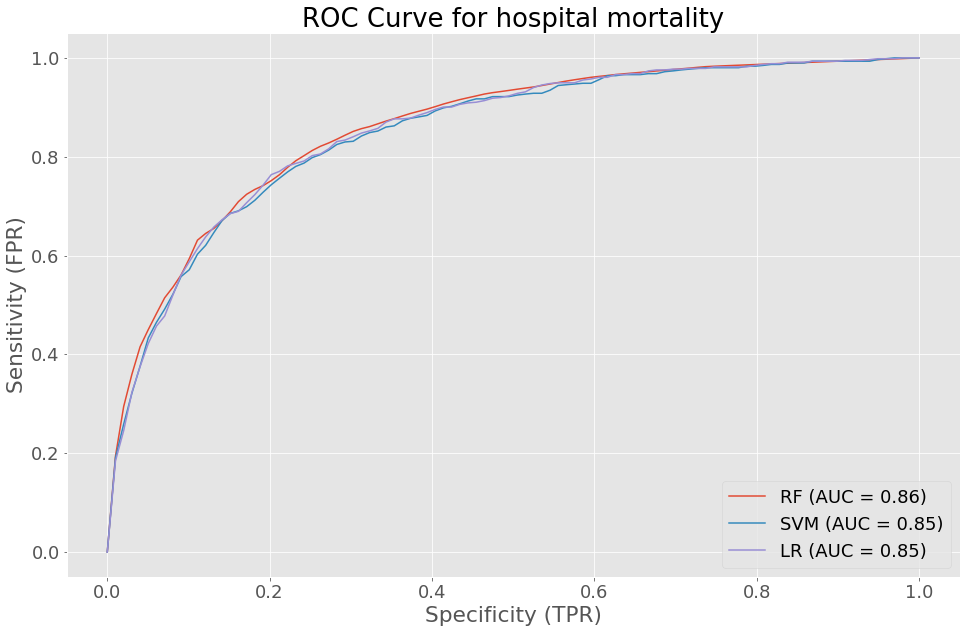

CPU times: user 4min 34s, sys: 2.13 s, total: 4min 36s
Wall time: 1min 19s


In [48]:
%%time

labels = BinaryLabels(np.array(y))

# Parameters to svm
C = 0.1
epsilon = 0.001

# Random Forest parameters
feature_types = np.zeros_like(features.columns, dtype=bool)
feature_types[np.where( (features.columns == 'admission_type') | (features.columns == 'first_careunit') |(features.columns == 'gender'))[0]] = True
m_vote = MeanRule()

k = 10
stratified_split = StratifiedCrossValidationSplitting(labels, k)

metric = ROCEvaluation()

stratified_split.build_subsets()
results = {}
total_results = {}

classifiers = {"LR": L2R_LR, "SVM": L2R_L2LOSS_SVC, "RF": None }#, "RBF": None } #,"LR": L2R_LR}
print("Evaluating classifiers...")

mean_fpr = np.linspace(0, 1, 100)
plt.figure(figsize=(16, 10))

y = outcomes['hospital7day_expire_flag'].replace(0, -1)

for classifier in classifiers:
    aucs = []
    print(classifier)
    mean_tpr = 0.0
    for i in range(k):
        train_idx = stratified_split.generate_subset_inverse(i)
        test_idx = stratified_split.generate_subset_indices(i)
        X_train = RealFeatures(np.array(X.loc[train_idx]).T)
        y_train = BinaryLabels(np.array(y.loc[train_idx]))    

        X_test = RealFeatures(np.array(X.loc[test_idx]).T)
        y_test = BinaryLabels(np.array(y.loc[test_idx]))

        preprocessor = PruneVarSubMean(True)
        preprocessor.init(X_train)
        X_train.add_preprocessor(preprocessor)
        X_train.apply_preprocessor(True)

        preprocessor.init(X_test)
        X_test.add_preprocessor(preprocessor)
        X_test.apply_preprocessor(True)            

        if classifier == "RBF":
            gauss_kernel = GaussianKernel(X_train, X_train, 15)
            clf = LibSVM(C, gauss_kernel, y_train)
            clf.set_epsilon(epsilon)
        elif classifier == "LR" or classifier == "SVM":
            clf = LibLinear(C, X_train, y_train)
            clf.set_liblinear_solver_type(classifiers[classifier])
            clf.set_epsilon(epsilon)
        elif classifier == "RF":
            y_train = MulticlassLabels(y_train)
            clf = RandomForest(X_train, y_train, 100)
            clf.set_combination_rule(m_vote)
            clf.set_feature_types(feature_types)            
        
        clf.train()

        y_pred = clf.apply_binary(X_test)

        roc = ROCEvaluation()
        roc.evaluate(y_pred, y_test)

        auc = roc.get_auROC()
        print("Fold", i, " auROC(%): ", auc)    
        aucs.append(auc)

        fpr, tpr = roc.get_ROC()
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0

    results[classifier] = aucs
    print("Mean auROC across all folds for", classifier, ":", np.mean(aucs))
    mean_tpr /= k
    mean_tpr[-1] = 1.0

    plt.plot(mean_fpr, mean_tpr, label='%s (AUC = %0.2f)' % (classifier, np.mean(aucs)))

plt.title('ROC Curve for hospital mortality')
plt.xlabel('Specificity (TPR)')
plt.ylabel('Sensitivity (FPR)')
    
plt.legend(loc='lower right')
plt.rc('font', size=18)

plt.show()

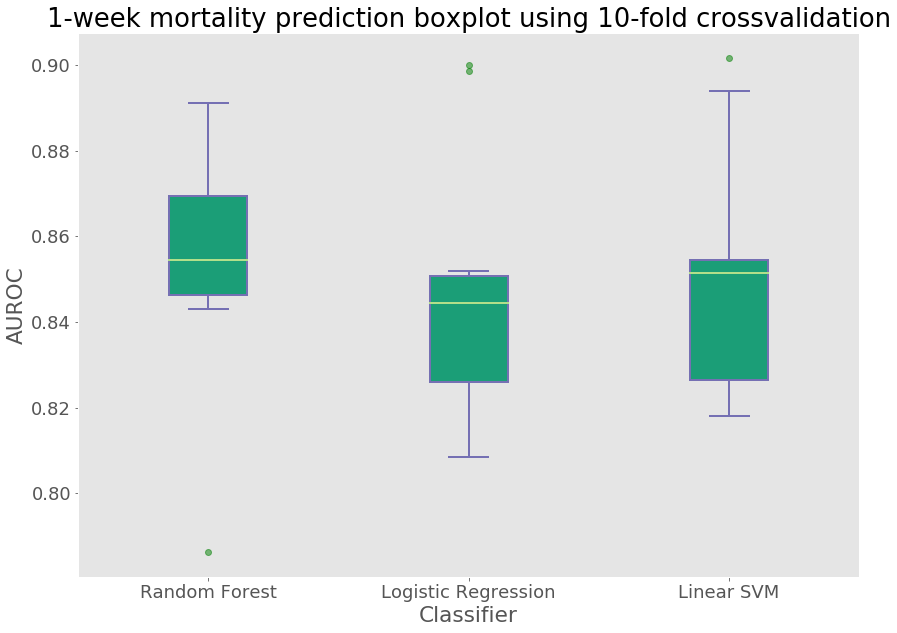

In [40]:
# styling taken from http://blog.bharatbhole.com/creating-boxplots-with-matplotlib/

aucs = [results[clf] for clf in results]
data = np.array(aucs).T
xlabels = [clf for clf in results]

plt.figure(figsize=(14, 10))
bp = plt.boxplot(data, 0, 'gD', patch_artist=True)
plt.ylabel('AUROC')
plt.xlabel('Classifier')
plt.xticks([1, 2, 3], ['Random Forest', 'Logistic Regression', 'Linear SVM'])
plt.title('1-week mortality prediction boxplot using 10-fold crossvalidation')
plt.grid(b=False)

## change outline color, fill color and linewidth of the boxes
for box in bp['boxes']:
    # change outline color
    box.set( color='#7570b3', linewidth=2)
    # change fill color
    box.set( facecolor = '#1b9e77' )

## change color and linewidth of the whiskers
for whisker in bp['whiskers']:
    whisker.set(color='#7570b3', linewidth=2)

## change color and linewidth of the caps
for cap in bp['caps']:
    cap.set(color='#7570b3', linewidth=2)

## change color and linewidth of the medians
for median in bp['medians']:
    median.set(color='#b2df8a', linewidth=2)

## change the style of fliers and their fill
for flier in bp['fliers']:
    flier.set(marker='o', color='#e7298a', alpha=0.5)
    
plt.show()

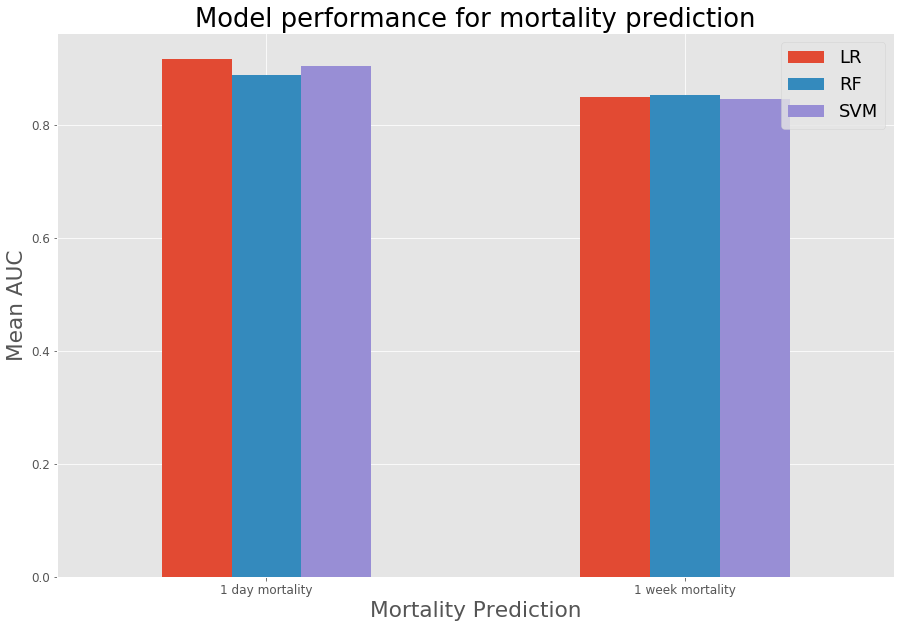

In [87]:
df_1day = pd.DataFrame(results_1day).describe().loc['mean', :]
df_7day = pd.DataFrame(results_1week).describe().loc['mean', :]

results_df = pd.concat((df_1day, df_7day), axis=1, keys=['LR', 'RF', 'SVM'])
results_df.columns = ['1-day mortality', '1-week mortality']
results_df = results_df.T

ax = results_df.plot.bar(figsize=(15,10), fontsize=12, title='Model performance for mortality prediction')
ax.set_ylabel('Mean AUC')
ax.set_xticklabels(['1 day mortality', '1 week mortality'], rotation=0)
ax.set_xlabel('Mortality Prediction')
ax.legend(loc='upper right')

## Length of stay

In [90]:
query_output.first_careunit = pd.Categorical(query_output.first_careunit)
query_output.gender = pd.Categorical(query_output.gender)
query_output.admission_type = pd.Categorical(query_output.admission_type)

query_output['gender'] = query_output.gender.cat.codes
query_output['first_careunit'] = query_output.first_careunit.cat.codes
query_output['admission_type'] = query_output.admission_type.cat.codes

query_output = query_output[(query_output.exclusion_los == 0) & (query_output.exclusion_age == 0) & (query_output.exclusion_first_stay == 0)]

los_names = ['hosp_los', 'icu_los']

feature_names = [
            # Demographic information
            'age_icu_in', 'gender', 'first_careunit',
            'admission_type',
    
            # Vital signs
            'heartrate_min', 'heartrate_max', 
            'meanbp_min', 'meanbp_max', 
            'diasbp_min', 'diasbp_max',
            'sysbp_min', 'sysbp_max',
            'resprate_min', 'resprate_max',
            'mingcs', 'gcsmotor',
            'gcsverbal', 'gcseyes',             
            'tempc_min', 'tempc_max',
            'spo2_min', 'spo2_max',
                 
            # Laboratory measurements
            'aniongap_min', 'aniongap_max',
            'bicarbonate_min', 'bicarbonate_max',
            'creatinine_min', 'creatinine_max',
            'chloride_min', 'chloride_max',
            'glucose_min', 'glucose_max',
            'hematocrit_min', 'hematocrit_max',
            'hemoglobin_min', 'hemoglobin_max',
            'platelet_min', 'platelet_max',
            'potassium_min', 'potassium_max',
            'sodium_min', 'sodium_max',
            'bun_min', 'bun_max',
            'wbc_min', 'wbc_max',                 
            
            # Other
            'vent', 
            'urineoutput'
            ]

query_output = query_output.loc[:, los_names + feature_names]
query_output = query_output.fillna(query_output.mean()).reset_index(drop=True)

#query_output = query_output.loc[:, los_names + feature_names].dropna().reset_index(drop=True)

outcomes = query_output.loc[:, los_names]
features = query_output.loc[:, query_output.columns.difference(los_names)]

X = features
y = outcomes['hosp_los']

print("Number of patients:", len(query_output))
query_output.tail()

32290


,hosp_los,icu_los,age_icu_in,gender,first_careunit,admission_type,heartrate_min,heartrate_max,meanbp_min,meanbp_max,...,potassium_min,potassium_max,sodium_min,sodium_max,bun_min,bun_max,wbc_min,wbc_max,vent,urineoutput
32285,2.9194,1.1234,54.623021,1,2,1,87.0,116.0,49.0,109.0,...,3.7,4.7,136.0,141.0,9.0,11.0,5.9,6.7,0,2875.0
32286,35.6549,28.7306,42.694761,1,4,1,86.0,134.0,3.0,162.0,...,3.4,4.1,139.0,141.0,13.0,16.0,11.6,12.3,0,3875.0
32287,1.5563,1.5601,83.197257,1,2,1,65.0,92.0,56.0,113.0,...,4.0,4.5,141.0,147.0,29.0,47.0,5.6,9.3,0,1725.0
32288,2.2396,1.2625,43.594414,0,0,1,58.0,80.0,49.0,105.0,...,3.8,4.1,139.0,140.0,12.0,13.0,11.7,11.8,0,1250.0
32289,10.0757,7.9493,65.158164,1,1,1,70.0,82.0,50.0,77.0,...,3.8,4.5,133.0,137.0,28.0,29.0,3.8,7.4,0,1800.0


In [91]:
split = int(len(X) * 0.7)

X_train = RealFeatures(np.array(X[:split].T))
X_test = RealFeatures(np.array(X[split:].T))

y_train = RegressionLabels(np.array(y[:split]))
y_test = RegressionLabels(np.array(y[split:]))

print("Number of training samples:", y_train.get_num_labels())
print("Number of testing samples:", y_test.get_num_labels())

('Number of training samples:', 22603)
('Number of testing samples:', 9687)


In [92]:
preprocessor = PruneVarSubMean(True)
preprocessor.init(X_train)
X_train.add_preprocessor(preprocessor)
X_train.apply_preprocessor(True)

preprocessor.init(X_test)
X_test.add_preprocessor(preprocessor)
X_test.apply_preprocessor(True)

True

In [93]:
%%time

# Load models
ls = LeastSquaresRegression(X_train, y_train)

tau = 1
rr = LinearRidgeRegression(tau, X_train, y_train)

# Train
ls.train()
rr.train()

metric = MeanSquaredError()

y_pred = ls.apply_regression(X_test)
mse = metric.evaluate(y_pred, y_test)
print("Least square regression MSE:", mse)
y_pred = rr.apply_regression(X_test)
mse = metric.evaluate(y_pred, y_test)
print("Linear ridge regression MSE:", mse)

('Least square regression MSE:', 107.96163709221118)
('Linear ridge regression MSE:', 107.96140739374331)
CPU times: user 176 ms, sys: 0 ns, total: 176 ms
Wall time: 75.3 ms


## With cross-validation

In [94]:
%%time

features = RealFeatures(np.array(X))
labels = RegressionLabels(np.array(y))

# Parameters to svm
k = 10
split = CrossValidationSplitting(labels, k)

metric = ROCEvaluation()
split.build_subsets()

classifiers = {'LSR': LeastSquaresRegression(), 'LLR': LinearRidgeRegression()}
tau = 1

regression_results = {}
total_regression_results = {}
total_regression_results['LSR'] = {}
total_regression_results['LLR'] = {}

print("Evaluating classifiers...")
for clf in classifiers:
    for outcome in los_names:
        y = outcomes[outcome]

        mses = []
        for i in range(k):    
            train_idx = split.generate_subset_inverse(i)
            test_idx = split.generate_subset_indices(i)
            X_train = RealFeatures(np.array(X.loc[train_idx]).T)
            y_train = RegressionLabels(np.array(y.loc[train_idx]))    
            X_test = RealFeatures(np.array(X.loc[test_idx]).T)
            y_test = RegressionLabels(np.array(y.loc[test_idx]))

            preprocessor = PruneVarSubMean(True)
            preprocessor.init(X_train)
            X_train.add_preprocessor(preprocessor)
            X_train.apply_preprocessor(True)

            preprocessor.init(X_test)
            X_test.add_preprocessor(preprocessor)
            X_test.apply_preprocessor(True)            
            
            if clf == 'LLR':
                classifiers[clf].set_tau(tau)

            classifiers[clf].set_features(X_train)
            classifiers[clf].set_labels(y_train)
            #ls = LeastSquaresRegression(X_train, y_train)

            classifiers[clf].train()

            metric = MeanSquaredError()

            y_pred = classifiers[clf].apply_regression(X_test)
            mse = metric.evaluate(y_pred, y_test)
            print("Fold %d, %s MSE:" % (i, clf), mse)
            mses.append(mse)
        regression_results[clf] = mses
        print('%s, Mean MSE (%s) across all folds:' % (clf, outcome), np.mean(mses))
        total_regression_results[clf][outcome] = mses

Evaluating classifiers...
('Fold 0, LLR MSE:', 104.5690684558809)
('Fold 1, LLR MSE:', 206.2590776398157)
('Fold 2, LLR MSE:', 111.72661598545176)
('Fold 3, LLR MSE:', 258.8124786098797)
('Fold 4, LLR MSE:', 86.26810926770361)
('Fold 5, LLR MSE:', 262.1900099281174)
('Fold 6, LLR MSE:', 104.85094990907061)
('Fold 7, LLR MSE:', 215.8059074830795)
('Fold 8, LLR MSE:', 104.8760054859063)
('Fold 9, LLR MSE:', 223.1865974737875)
('LLR, Mean MSE (hosp_los) across all folds:', 167.85448202386928)
('Fold 0, LLR MSE:', 30.508262206208425)
('Fold 1, LLR MSE:', 52.18305889255327)
('Fold 2, LLR MSE:', 34.17147527567115)
('Fold 3, LLR MSE:', 62.140667474066355)
('Fold 4, LLR MSE:', 35.592020999789064)
('Fold 5, LLR MSE:', 74.57425781248384)
('Fold 6, LLR MSE:', 31.374847147354277)
('Fold 7, LLR MSE:', 56.45557162029076)
('Fold 8, LLR MSE:', 37.18093056530095)
('Fold 9, LLR MSE:', 54.96375266556725)
('LLR, Mean MSE (icu_los) across all folds:', 46.914484465928538)
('Fold 0, LSR MSE:', 104.5692266104

## Time series

The previous basic model above that was built for mortality prediction was based on a single time-shot features i.e. vital signs of the first 24 hours were aggregated and had descriptive statistics computed. As a result, the basic model fails to account any temporal structure in the data and will not capture a changing health status of a patient.

Let’s recall that the objective was to develop a model that could allow caregivers to monitor and predict mortality of patients. In practice, such a system would be incorporated in a real-time clinical monitoring system where it would be possible to look at a patient at any point in time and make a prediction about whether the patient will die within a certain amount of time. The previous model is limited in the sense that it doesn’t account for predictions at any point in time, since it’s trained with data from only the first 24 hours combined.

In this improved model, I exploit the temporal information, taking into account the fluctuations of the vital signs over time and most importantly does not look at how the vital signs change moments before death. From there, it allowed me to better understand how a dying patient differs from a patient with normal behavior moments before days, hours and right before death.


### Resampling

One of the challenges with the MIMIC database is that vital signs are measured and recorded at irregular time intervals. Resampling refers to converting raw time series data into discrete intervals at a fixed frequency. A smaller time resolution between vital sign readings, the better and more accurate the classifier becomes since it allows for timely predictions.

Because space and computing power is limited, a sampling rate measuring capturing vital signs every hour was chosen, for the first 24 hours of a patient. Afterwards, lagged features from the last 3 hourly observations (t-1, t-2, t-3), which are the vital signs at the previous hours, were computed by shifting columns of the time stamp.

A rolling window then computes the mean, min, max and median over the entire vital signs time series of a patient in the last 6 hours. The same vital signs used previously were included for this model. Below is a sample of data points with only heart rate used.

In [ ]:
sql_path = os.path.join(SHOGUN_DATA_DIR, 'data_project/mimic/first-icustay-timeseries.sql')
with open(sql_path, 'r') as f:
    query = f.read()
    query_output = pd.read_sql_query(query, con)

query_output = pd.read_sql_query(query, con)
query_output.head()

In [11]:
query_output = query_output.dropna(subset=['timestamp'], how='any')
query_output= query_output.set_index('timestamp')

query_output.first_careunit = pd.Categorical(query_output.first_careunit)
query_output.gender = pd.Categorical(query_output.gender)
query_output.admission_type = pd.Categorical(query_output.admission_type)

query_output['gender'] = query_output.gender.cat.codes
query_output['first_careunit'] = query_output.first_careunit.cat.codes
query_output['admission_type'] = query_output.admission_type.cat.codes

query_output = query_output[(query_output.exclusion_los == 0) & (query_output.exclusion_age == 0) 
                            & (query_output.exclusion_first_stay == 0) ]#& (query_output.age_icu_in < 250)]

# Median age of patients > 89 is 91.6
query_output.loc[query_output.age_icu_in > 89, 'age_icu_in'] = 91.6

mortality_names = ['hospital_expire_flag', 'icu_expire_flag', 
                   'dod_hosp', 'dead_in_1d', 'dead_in_7d']

# Demographic information
demographics =  ['subject_id', 'age_icu_in', 'gender', 
                 'first_careunit', 'admission_type', 'icu_los']

vital_signs = ['hr', 'diasbp', 'sysbp', 'meanbp', 'resprate', 'tempc', 'spo2']
features = [[v, v + '_mean_6h', v + '_median_6h', v + '_max_6h', v + '_min_6h', 
             v + '_1h', v + '_2h', v + '_3h'] for v in vital_signs]
feature_names = []
for f in features:
    feature_names += f
    
query_output = query_output.loc[:, mortality_names + demographics + feature_names]
query_output = query_output.fillna(query_output.mean())
query_output.index = pd.to_datetime(query_output.index)

# Remove points after a patient has already died
will_die = (~query_output.dod_hosp.isnull())
point_after_dead = (query_output.index > pd.DatetimeIndex(query_output.dod_hosp))
query_output = query_output.loc[~(will_die & point_after_dead)]

df_labels = query_output.loc[:, mortality_names]
df_features = query_output.loc[:, query_output.columns.difference(mortality_names)]

df_features.head()

,admission_type,age_icu_in,diasbp,diasbp_1h,diasbp_max_6h,diasbp_mean_6h,diasbp_median_6h,diasbp_min_6h,first_careunit,gender,...,sysbp_max_6h,sysbp_mean_6h,sysbp_median_6h,sysbp_min_6h,tempc,tempc_1h,tempc_max_6h,tempc_mean_6h,tempc_median_6h,tempc_min_6h
timestamp,,,,,,,,,,,,,,,,,,,,,
2111-11-07 02:00:00,1,37.446714,54.0,60.571963,54.0,53.500000,53.5,53.0,2,0,...,108.0,107.500000,107.5,107.0,37.388891,36.975663,37.388891,37.388891,37.388891,37.388891
2111-11-07 03:00:00,1,37.446714,60.0,54.000000,60.0,55.666667,54.0,53.0,2,0,...,108.0,107.333333,107.0,107.0,36.978712,37.388891,37.388891,37.388891,37.388891,37.388891
2111-11-07 04:00:00,1,37.446714,56.0,60.000000,60.0,55.750000,55.0,53.0,2,0,...,108.0,106.000000,107.0,102.0,36.978712,36.975663,37.388891,37.388891,37.388891,37.388891
2111-11-07 05:00:00,1,37.446714,50.0,56.000000,60.0,55.000000,55.0,50.0,2,0,...,107.0,103.000000,104.5,96.0,36.978712,36.975663,37.388891,37.388891,37.388891,37.388891
2111-11-07 06:00:00,1,37.446714,40.5,50.000000,60.0,52.100000,54.0,40.5,2,0,...,107.0,101.200000,102.0,94.0,36.777778,36.975663,37.388891,37.083334,37.083334,36.777778


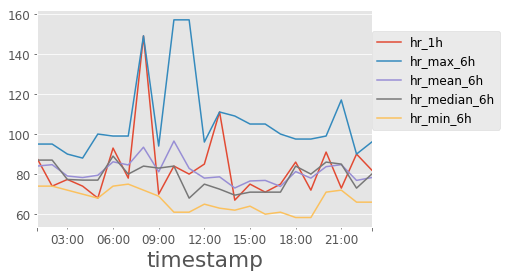

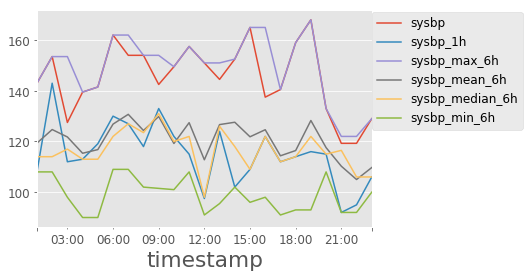

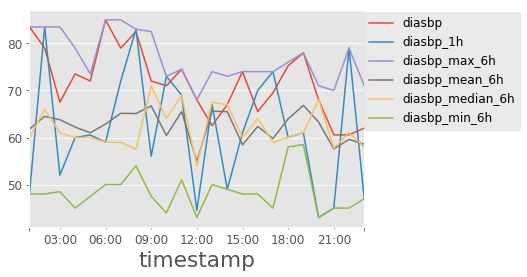

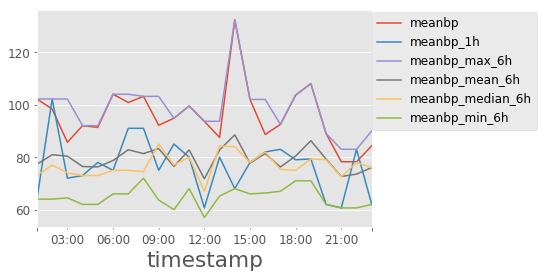

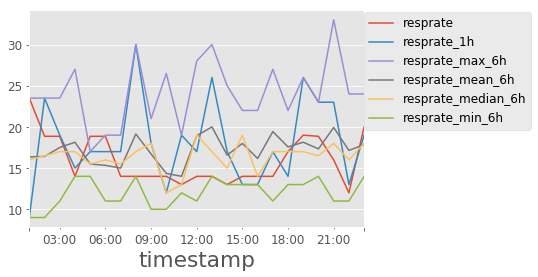

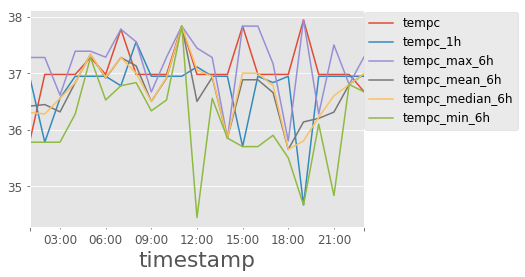

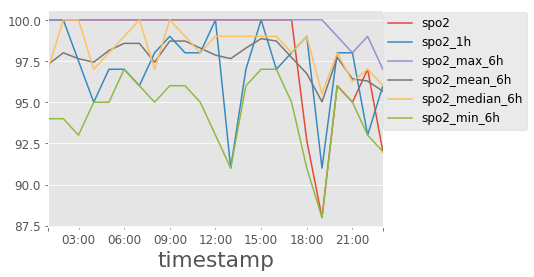

In [110]:
non_survival = df_features.loc[df_labels.dead_in_1d != 0]
non_surv_rows = np.random.choice(non_survival.subject_id.values, 1)
non_survival = non_survival.loc[non_survival.subject_id.isin(non_surv_rows)]

feats = ['hr', 'sysbp', 'diasbp', 'meanbp', 'resprate', 'tempc', 'spo2']
for title, group in non_survival.groupby('subject_id'):
    for f in feats:
        group.filter(regex=f).plot(fontsize=12)
        plt.legend(fontsize=12, loc=(1, 0.45))

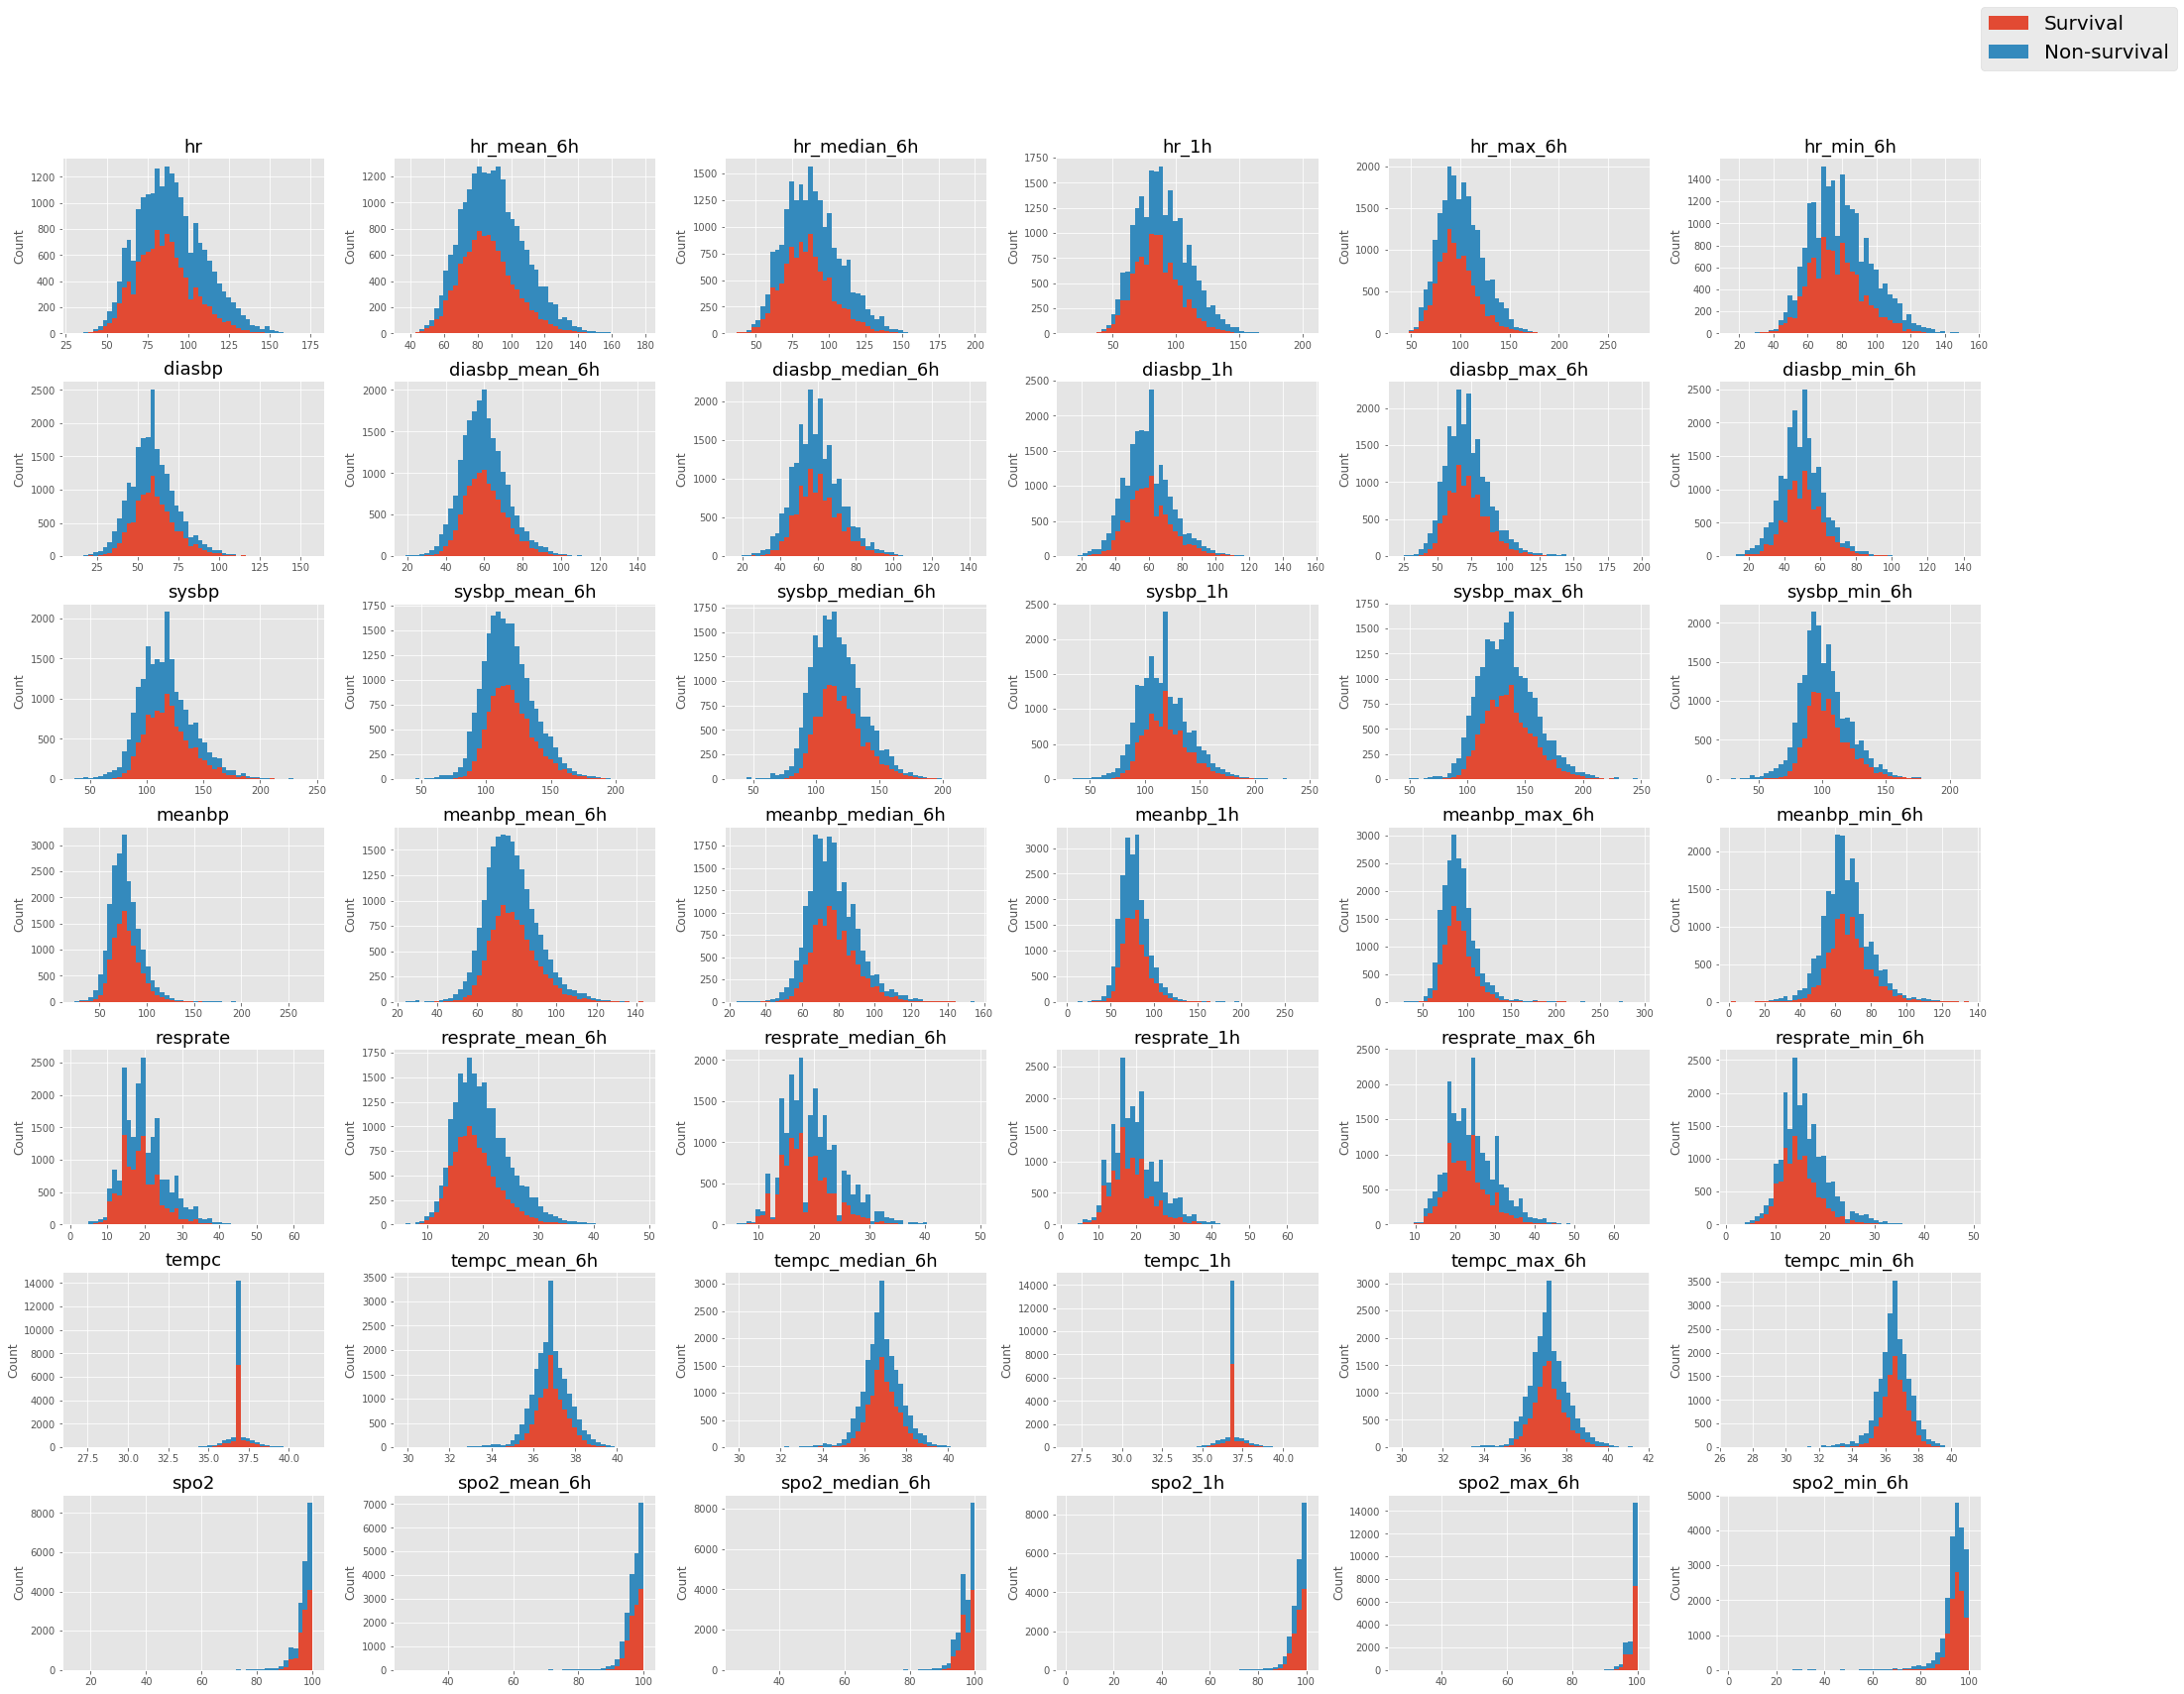

In [8]:
will_die = (~query_output.dod_hosp.isnull())
died = query_output.loc[will_die]
survived = query_output.loc[~will_die]

died = df_features.loc[df_labels.dead_in_1d != 0]
survived = df_features.loc[df_labels.dead_in_1d == 0].sample(n=len(died))

f, axarr = plt.subplots(7, 6, figsize=(28, 22))

i = -1
for idx, feature_name in enumerate(feature_names):
    x1 = survived.loc[:, feature_name].dropna()
    x2 = died.loc[:, feature_name].dropna()
    if idx % 6 == 0:
        i += 1
    p = axarr[i, idx % 6].hist([x1, x2], stacked=True, bins=50, normed=False)
    axarr[i, idx % 6].set_ylabel('Count')
    axarr[i, idx % 6].set_title(feature_name, fontsize=18)
    
axarr[0, 5].legend(['Survival', 'Non-survival'], loc=(1, 1.5), fontsize=20)
    
plt.tight_layout()

## Data preparation

In [18]:
X = df_features.drop('subject_id', axis=1).reset_index(drop=True)
y = df_labels['dead_in_7d'].reset_index(drop=True)

dataset_size = 100000
subset_idx = np.random.choice(len(df_features), dataset_size)

X = X.loc[subset_idx].reset_index(drop=True)
y = y.loc[subset_idx].reset_index(drop=True)

split = int(len(X) * 0.5)

idx = np.random.permutation(np.arange(len(y)))
train_idx = idx[:split]
test_idx = idx[split:]

X_train = RealFeatures(np.array(X.loc[train_idx].T))
X_test = RealFeatures(np.array(X.loc[test_idx].T))

y_train = MulticlassLabels(np.array(y.loc[train_idx]).astype(np.float))
y_test = MulticlassLabels(np.array(y.loc[test_idx]).astype(np.float))

print("Number of training samples:", y_train.get_num_labels())
print("Number of testing samples:", y_test.get_num_labels())

preprocessor = PruneVarSubMean(True)
preprocessor.init(X_train)
X_train.add_preprocessor(preprocessor)
X_train.apply_preprocessor(True)

preprocessor.init(X_test)
X_test.add_preprocessor(preprocessor)
X_test.apply_preprocessor(True)

('Number of training samples:', 50000)
('Number of testing samples:', 50000)


True

In [19]:
print("Number of positive (death) labels: ", sum(y == 1))
print("Number of negative (alive) labels: ", sum(y == 0))

print("positive/negative ratio:", sum(y == 0) / float(sum(y == 1)))

('Number of positive (death) labels: ', 6492)
('Number of negative (alive) labels: ', 93508)
('positive/negative ratio:', 14.403573629081947)


## Evaluation

Three classifiers (logistic regression, linear SVM and random forest) were evaluated and compared. One challenge I faced was dealing with class imbalance where the number of negative samples (patients that did not die) was significantly larger than the number of positive samples (patients that died). This was addressed by undersampling the negative samples to maintain a ratio of 80/20. In addition, because the size of the dataset consisted of over 500,000 data points, the training and testing set were subsampled and evaluated several times. The subset of the data consisted of 100,000 points and split in two for training and testing, and averaged over 10 runs. 

In [32]:
%%time
dataset_size = 100000
n_trees = 100
feature_types = np.zeros_like(X.columns, dtype=bool)
feature_types[np.where( (X.columns == 'admission_type') | (X.columns == 'first_careunit') |(X.columns == 'gender'))[0]] = True

C = 0.1
epsilon = 0.001

svm_aucs = []
lr_aucs = []
rf_aucs = []
roc = ROCEvaluation()

for i in range(10):
    print("Iteration:", i)
    
    X = df_features.drop('subject_id', axis=1).reset_index(drop=True)
    y = df_labels['dead_in_7d'].reset_index(drop=True)    
    # Randomly select 100,000 points
    subset_idx = np.random.choice(len(y), dataset_size)
    X = X.loc[subset_idx].reset_index(drop=True)
    y = y.loc[subset_idx].reset_index(drop=True)

    split = int(len(X) * 0.5)

    idx = np.random.permutation(np.arange(len(y)))
    train_idx = idx[:split]
    test_idx = idx[split:]

    X_train = RealFeatures(np.array(X.loc[train_idx].T))
    X_test = RealFeatures(np.array(X.loc[test_idx].T))

    y_train = MulticlassLabels(np.array(y.loc[train_idx]).astype(np.float))
    y_test = MulticlassLabels(np.array(y.loc[test_idx]).astype(np.float))

    preprocessor = PruneVarSubMean(True)
    preprocessor.init(X_train)
    X_train.add_preprocessor(preprocessor)
    X_train.apply_preprocessor(True)

    preprocessor.init(X_test)
    X_test.add_preprocessor(preprocessor)
    X_test.apply_preprocessor(True)    
    
    # SVM
    svm = LibLinear(C, X_train, y_train.get_binary_for_class(1))
    svm.set_liblinear_solver_type(L2R_L2LOSS_SVC)
    svm.set_epsilon(epsilon)
    svm.train()
    y_pred = svm.apply_binary(X_test)
    roc.evaluate(y_pred, y_test.get_binary_for_class(1))
    auc = roc.get_auROC()
    svm_aucs.append(auc)
    
    # Logistic regression
    svm = LibLinear(C, X_train, y_train.get_binary_for_class(1))
    svm.set_liblinear_solver_type(L2R_LR)
    svm.set_epsilon(epsilon)
    svm.train()
    y_pred = svm.apply_binary(X_test)
    roc.evaluate(y_pred, y_test.get_binary_for_class(1))
    auc = roc.get_auROC()
    lr_aucs.append(auc)
    
    # Random Forest
    feature_types = np.zeros_like(X.columns, dtype=bool)
    feature_types[np.where( (X.columns == 'admission_type') | (X.columns == 'first_careunit') |(X.columns == 'gender'))[0]] = True
    
    m_vote = MeanRule()
    rand_forest = RandomForest(X_train, y_train, n_trees)
    rand_forest.set_combination_rule(m_vote)
    rand_forest.set_feature_types(feature_types)
    rand_forest.train()
    y_pred = rand_forest.apply_binary(X_test)
    roc.evaluate(y_pred, y_test.get_binary_for_class(1))
    auc = roc.get_auROC()
    rf_aucs.append(auc)

('Iteration:', 0)
('Iteration:', 1)
('Iteration:', 2)
('Iteration:', 3)
('Iteration:', 4)
('Iteration:', 5)
('Iteration:', 6)
('Iteration:', 7)
('Iteration:', 8)
('Iteration:', 9)
CPU times: user 1h 46min 18s, sys: 38.5 s, total: 1h 46min 56s
Wall time: 35min 13s


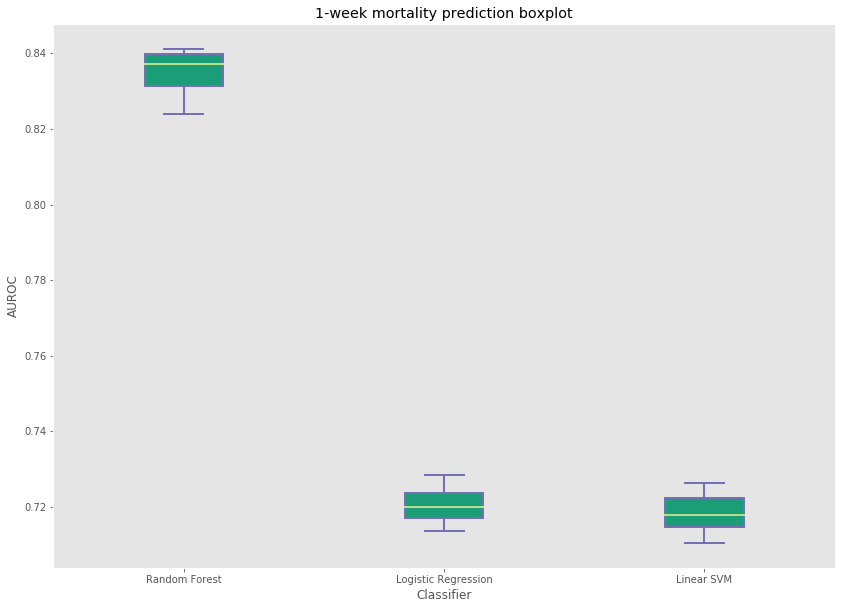

In [33]:
# styling taken from http://blog.bharatbhole.com/creating-boxplots-with-matplotlib/

aucs = [rf_aucs, lr_aucs, svm_aucs]
data = np.array(aucs).T
xlabels = [0, 1, 2] #[clf for clf in results]

plt.figure(figsize=(14, 10))
bp = plt.boxplot(data, 0, 'gD', patch_artist=True)
plt.ylabel('AUROC')
plt.xlabel('Classifier')
plt.xticks([1, 2, 3], ['Random Forest', 'Logistic Regression', 'Linear SVM'])
plt.title('1-week mortality prediction boxplot')
plt.grid(b=False)

## change outline color, fill color and linewidth of the boxes
for box in bp['boxes']:
    # change outline color
    box.set( color='#7570b3', linewidth=2)
    # change fill color
    box.set( facecolor = '#1b9e77' )

## change color and linewidth of the whiskers
for whisker in bp['whiskers']:
    whisker.set(color='#7570b3', linewidth=2)

## change color and linewidth of the caps
for cap in bp['caps']:
    cap.set(color='#7570b3', linewidth=2)

## change color and linewidth of the medians
for median in bp['medians']:
    median.set(color='#b2df8a', linewidth=2)

## change the style of fliers and their fill
for flier in bp['fliers']:
    flier.set(marker='o', color='#e7298a', alpha=0.5)
    
plt.show()

## Conclusion

I first started off with a basic model using demographic information, vital signs and laboratory measurements for predicting patient mortality. Using three common machine learning classifiers, I was able to obtain decent results of 85% AUC. However, ignoring the temporal component of the data reduced the predictive power of my models, since I used a single time-shot of all vital signs to predict mortality. In the second,improved model, I added lagged features and computed sliding window summary statistics for the vital signs. The latter model ended up being much more realistic and capable of making better predictions at any point in time since it took into account the time series data.

